In [119]:
import os 
import pandas as pd
import pickle
import tensorflow as tf
import numpy as np

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras import utils 
from tensorflow.keras import layers
from tensorflow.keras import models

In [120]:
file = '../../data/data_model/data_epoching_stft_new.ftr'

In [121]:
if file.endswith('.csv'):
    data= pd.read_csv(file,index_col=0)
elif file.endswith('.ftr'):
    data= pd.read_feather(file)
print(data.shape)
data.label.value_counts()

In [ ]:
data = model_training.select_n_sample(data,80000)
data.label.value_counts()

In [ ]:
X = data.drop(columns='label').to_numpy()
y = data['label'].to_numpy()

In [122]:
X = np.reshape(X, (*X.shape,1))

In [123]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify=y, test_size=0.33, random_state=42)
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

<h1> Deep Learning Model<h1>

In [126]:
input_shape = X.shape[1:]
n_classes= len(le.classes_)
print(input_shape,n_classes)

filter_size = 3
# Construct model 
model = models.Sequential()
model.add(layers.Conv2D(filters=16, kernel_size=filter_size,
                 input_shape=input_shape, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=64, kernel_size=filter_size,
                 input_shape=input_shape, activation='relu'))
model.add(layers.MaxPooling2D(2))
model.add(layers.Dropout(0.5))
model.add(layers.Conv2D(filters=128, kernel_size=filter_size,
                 input_shape=input_shape, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.GlobalMaxPooling2D())
model.add(layers.Dense(3, activation='softmax')) 
model.summary()

(77, 674, 1) 3
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_123 (Conv2D)         (None, 75, 672, 16)       160       
                                                                 
 max_pooling2d_94 (MaxPoolin  (None, 37, 336, 16)      0         
 g2D)                                                            
                                                                 
 dropout_55 (Dropout)        (None, 37, 336, 16)       0         
                                                                 
 conv2d_124 (Conv2D)         (None, 35, 334, 64)       9280      
                                                                 
 max_pooling2d_95 (MaxPoolin  (None, 17, 167, 64)      0         
 g2D)                                                            
                                                                 
 dropout_56 (Dropout)        (None, 17

In [128]:
from keras import backend as K

callback = tf.keras.callbacks.EarlyStopping(patience=10, 
                          verbose=1, 
                          min_delta=0.001, 
                          monitor='val_prc', 
                          mode='max', 
                          restore_best_weights=True)

model.compile(loss='sparse_categorical_crossentropy', optimizer='nadam', metrics=['accuracy'])
K.set_value(model.optimizer.learning_rate, 0.001)

history = model.fit(Xtrain,
          ytrain,
          epochs=100,
          validation_data=(Xtest, ytest))

Epoch 1/100
23/23 [==============================] - 9s 389ms/step - loss: 114.0464 - accuracy: 0.7323 - val_loss: 22.8160 - val_accuracy: 0.8641
Epoch 2/100
23/23 [==============================] - 8s 354ms/step - loss: 85.2292 - accuracy: 0.7459 - val_loss: 14.4403 - val_accuracy: 0.8641
Epoch 3/100
23/23 [==============================] - 8s 355ms/step - loss: 34.1208 - accuracy: 0.7690 - val_loss: 9.2735 - val_accuracy: 0.3750
Epoch 4/100
23/23 [==============================] - 8s 366ms/step - loss: 25.8702 - accuracy: 0.7663 - val_loss: 18.9377 - val_accuracy: 0.0543
Epoch 5/100
23/23 [==============================] - 8s 368ms/step - loss: 18.2377 - accuracy: 0.7717 - val_loss: 11.0905 - val_accuracy: 0.1033
Epoch 6/100
23/23 [==============================] - 8s 361ms/step - loss: 16.9547 - accuracy: 0.7772 - val_loss: 4.2033 - val_accuracy: 0.3424
Epoch 7/100
23/23 [==============================] - 9s 385ms/step - loss: 13.9985 - accuracy: 0.7663 - val_loss: 2.5951 - val_accu

Text(0.5, 1.0, 'Loss')

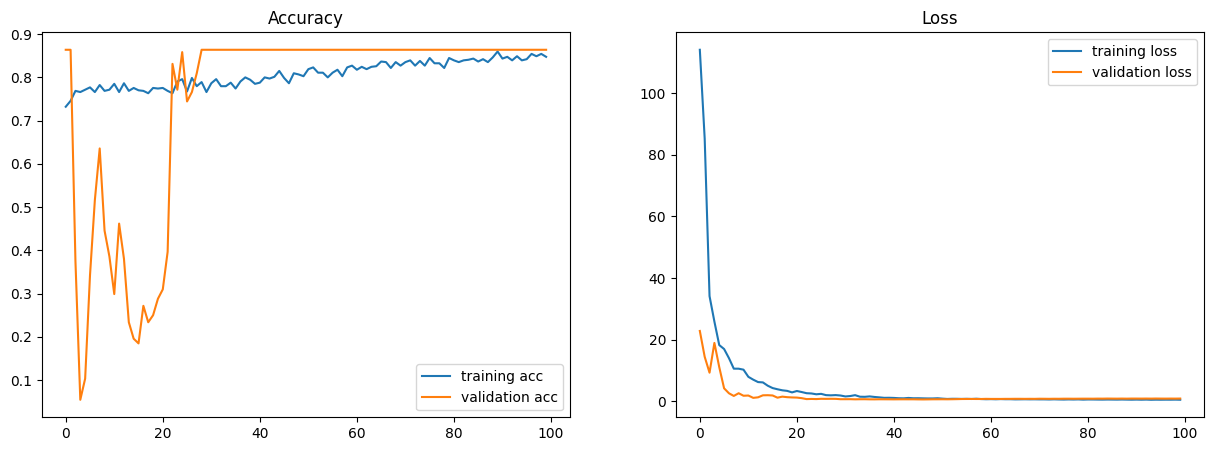

In [129]:
import matplotlib.pyplot as plt
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label = 'training acc')
plt.plot(history.history['val_accuracy'], label = 'validation acc')
plt.legend()
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label = 'training loss')
plt.plot(history.history['val_loss'], label = 'validation loss')
plt.legend()
plt.title('Loss')

In [130]:
print("Evaluate model on test data")
results = model.evaluate(Xtest, ytest)
print("test loss, test acc:", results)

Evaluate model on test data
6/6 [==============================] - 0s 79ms/step - loss: 0.8802 - accuracy: 0.8641
test loss, test acc: [0.8802042603492737, 0.864130437374115]


In [131]:
from sklearn.metrics import classification_report, confusion_matrix
y_predict = model.predict(Xtest)
y_predict = np.argmax(y_predict,axis=1)
confusion_matrix(ytest, y_predict)

6/6 [==============================] - 1s 78ms/step


array([[159,   0,   0],
       [  7,   0,   0],
       [ 18,   0,   0]])

In [132]:
print(classification_report(ytest, y_predict, target_names=le.classes_))

                       precision    recall  f1-score   support

                 COPD       0.86      1.00      0.93       159
              Healthy       0.00      0.00      0.00         7
respiratory_infection       0.00      0.00      0.00        18

             accuracy                           0.86       184
            macro avg       0.29      0.33      0.31       184
         weighted avg       0.75      0.86      0.80       184



/Users/bastienorset/Documents/git/respiratory_sound/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bastienorset/Documents/git/respiratory_sound/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/bastienorset/Documents/git/respiratory_sound/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c